# Introduction
Welcome to my project! In this Jupyter Notebook, I analyze the effects of ENSO (El-Nino and La-Nina) on tropical cyclone development in the Atlantic and East Pacific Basins. As we've learned in this class, El-Nino/La-Nina has a number of global effects, such as changes in precipitation/temperature patterns. I was interested in learning more about the effect that El-Nino/La-Nina has on tropical cyclones in the Atlantic and the East Pacific basins, given how significantly these systems can affect us. According to researchers, El Nino increases the number of tropical systems in the East Pacific while decreasing the number of storms in the Atlantic for a given year. On the other hand, La-Nina does the opposite. The cause of this is complex, but researchers believe ENSO influences the amount of wind shear in each basin, which affects tropical cyclone development and strength. See below images from NOAA which provide a good summary of the phenomena. The purpose of this project is to verify whether this is true (I believe it is), while also assessing ENSO impacts on hurricane strength and the number of landfalling tropical systems. Analysis is done on a yearly basis aka for each hurricane season.  

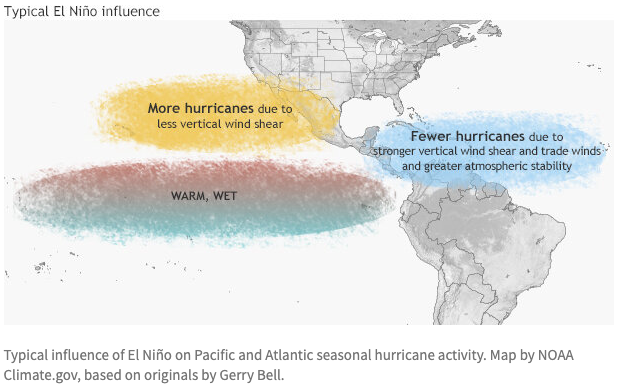







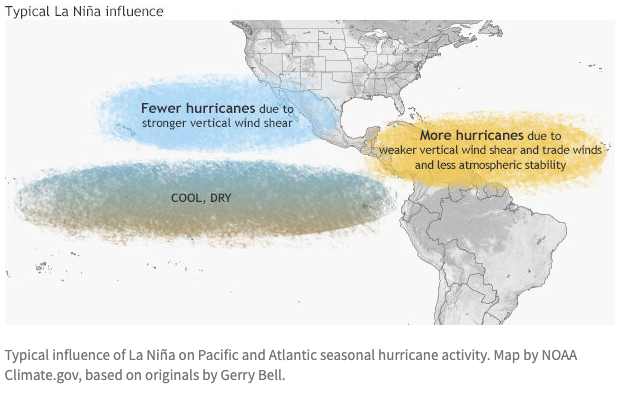

# Data 

In order to evaluate the hypothesis above, I used three datasets, all of which are readily available online. The first dataset is called the "Oceanic Nino Index" which is a monthly 3-month running mean of sea surface temperature (SST) anomalies in the Nino 3.4 region since 1950. The second and third dataset is the hurdat2 dataset for the Atlantic & NE Pacific Basins respectively. The hurdat2 database contains valuable information on tropical cyclones such as storm name/ID, track, whether a storm has made landfall, wind speed, and minimum pressure. This data is reported for every 6 hours from 1850 for the Atlantic & 1949 for the Pacific basins. For our analysis we only consider data from 1950 onwards. As seen in the cells below, I will carefully merge these datasets together to facilitate efficienct groupby data selection. 

In [286]:
# Import Packages
import xarray as xr
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import urllib.request 
import zipfile 
import math 
from scipy import stats
from scipy.stats import poisson, chisquare, mannwhitneyu, kstest
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
import warnings

# Data Processing

Processing techniques in this section include dropping NaN's, merging and grouping. 

In [333]:
### Oceanic Nino Index Reading in & Initial Processing 

#Read in Ocean-Nino-Index Data (Monthly)
ONI = pd.read_csv('ONI_1950_2022.txt',delim_whitespace=True,skiprows=9)

#Process data (get rid of NaN's, other unnecessary junk in header of text file)
ONI['YR'] = ONI['YR'].astype(str)
ONI['YR'] = ONI['YR'].str.replace('\\','')
ONI.rename(columns={'YR':'ONI_Anomaly_C','\outl0\strokewidth0':'Month','\strokec3':'Year'},inplace=True)
ONI = ONI[ONI['Month']!='}']
ONI.dropna(axis=1,inplace=True)

# ENSO is defined over 3 month averages. Mapping the 3 month period corresponding to each month to simplify analysis.
replace_dict = {'DJF': 'Jan', 'JFM': 'Feb', 'FMA': 'Mar', 'MAM': 'Apr', 'AMJ': 'May', 'MJJ': 'Jun', 'JJA': 'Jul', 'JAS': 'Aug', 'ASO':'Sep', 'SON':'Oct', 'OND':'Nov', 'NDJ':'Dec'}

# use replace method with dictionary
ONI['Month'] = ONI['Month'].str.replace('|'.join(replace_dict.keys()), lambda x: replace_dict[x.group()])

#create datetime object
time_string = ONI['Month'] + ' ' + ONI['Year'].astype(int).astype(str)

#Set datetime to index
ONI['time'] = pd.to_datetime(time_string)
ONI.set_index('time',inplace=True)

# Make sure ONI anomaly is in the right data format 
ONI['ONI_Anomaly_C']=ONI['ONI_Anomaly_C'].astype(float)
ONI['Year']=ONI['Year'].astype(int)

#Get sneak peek of dataset
ONI.head(5)


,Month,Year,SEAS,ONI_Anomaly_C
time,,,,
1950-01-01,Jan,1950,24.72,-1.53
1950-02-01,Feb,1950,25.17,-1.34
1950-03-01,Mar,1950,25.75,-1.16
1950-04-01,Apr,1950,26.12,-1.18
1950-05-01,May,1950,26.32,-1.07


In [288]:
#### Read in hourly Hurricane HURDAT2 Data (Atlantic Basin) & Initial Processing

# Initialize two empty data frames
df_main = pd.DataFrame()
df_header = pd.DataFrame()

# Open the text file for reading
with open('hurdat2-1851-2021-100522.txt', 'r') as file:
    # Read each line of the file
    for line in file:
        # Check if the line contains "AL"
        if "AL" in line:
            # Add the line to the AL data frame
            df_header = pd.concat([df_header, pd.DataFrame([line.strip().split(',')])], ignore_index=True)
        else:
            # Add the line to the main data frame
            df_main = pd.concat([df_main, pd.DataFrame([line.strip().split(',')])], ignore_index=True)

#Duplicate each row based on the value in the third column
df_header = df_header.loc[df_header.index.repeat(df_header.iloc[:,2])].reset_index(drop=True)

df_header.drop(df_header.columns[-1], axis=1, inplace=True)

df = pd.concat([df_header,df_main],ignore_index=True,axis=1)

df.drop(columns=range(10,24),inplace=True)

#Post-Process Atlantic Hurricane Data 

column_names = ['ID','Name','Num_Data_Pts','yyyy_mm_dd','Hour','Note','Type','Lat','Lon','Max_W_kt']
df = df.set_axis(column_names,axis=1)
df.head(5)
string = df['yyyy_mm_dd']+df['Hour']
datetime_string = pd.to_datetime(string,format='%Y%m%d %H%M')
df['time'] = datetime_string 
df.set_index('time',inplace=True)


Atlantic_TC = df 


,ID,Name,Num_Data_Pts,yyyy_mm_dd,Hour,Note,Type,Lat,Lon,Max_W_kt
time,,,,,,,,,,
1851-06-25 00:00:00,AL011851,UNNAMED,14,18510625,0000,,HU,28.0N,94.8W,80
1851-06-25 06:00:00,AL011851,UNNAMED,14,18510625,0600,,HU,28.0N,95.4W,80
1851-06-25 12:00:00,AL011851,UNNAMED,14,18510625,1200,,HU,28.0N,96.0W,80
1851-06-25 18:00:00,AL011851,UNNAMED,14,18510625,1800,,HU,28.1N,96.5W,80
1851-06-25 21:00:00,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2N,96.8W,80
1851-06-26 00:00:00,AL011851,UNNAMED,14,18510626,0000,,HU,28.2N,97.0W,70
1851-06-26 06:00:00,AL011851,UNNAMED,14,18510626,0600,,TS,28.3N,97.6W,60
1851-06-26 12:00:00,AL011851,UNNAMED,14,18510626,1200,,TS,28.4N,98.3W,60
1851-06-26 18:00:00,AL011851,UNNAMED,14,18510626,1800,,TS,28.6N,98.9W,50


In [4]:
### Read in hourly Hurricane Data (Pacific Basin) & Initial Processing

# Initialize two empty data frames
df_main = pd.DataFrame()
df_header = pd.DataFrame()

# Open the text file for reading
with open('hurdat2-nepac-1949-2021-091522.txt', 'r') as file:
    # Read each line of the file
    for line in file:
        # Check if the line contains "EP or CP"
        if "EP" in line or "CP" in line:
            # Add the line to the CP/EP data frame
            df_header = pd.concat([df_header, pd.DataFrame([line.strip().split(',')])], ignore_index=True)
        else:
            # Add the line to the main data frame
            df_main = pd.concat([df_main, pd.DataFrame([line.strip().split(',')])], ignore_index=True)

#Duplicate each row based on the value in the third column
df_header = df_header.loc[df_header.index.repeat(df_header.iloc[:,2])].reset_index(drop=True)

df_header.drop(df_header.columns[-1], axis=1, inplace=True)

df = pd.concat([df_header,df_main],ignore_index=True,axis=1)

df.drop(columns=range(10,24),inplace=True)

#Post-Process Pacific Hurricane Data 

column_names = ['ID','Name','Num_Data_Pts','yyyy_mm_dd','Hour','Note','Type','Lat','Lon','Max_W_kt']
df = df.set_axis(column_names,axis=1)
df.head(5)
string = df['yyyy_mm_dd']+df['Hour']
datetime_string = pd.to_datetime(string,format='%Y%m%d %H%M')
df['time'] = datetime_string 
df.set_index('time',inplace=True)

Pacific_TC = df 



In [334]:
warnings.filterwarnings('ignore')
# Merge ONI data to both atlantic/pacific datasets, add ENSO state column. Merging will make future groupby analysis
# much easier. 

# ENSO state column refers to whether an Oceanic Nino Index (ONI) anomaly reaches the threshold of El-Nino (>0.5)
# La Nina (<-0.5) or Neutral (b/w -0.5 and 0.5). This categorical characterization of ONI anomaly will be used to 
# group data corresponding with El-Nino or La-Nina years.  

#Resample ONI data in order to merge w/ hurdat dataset (which is hourly)
ONI_resampled = ONI.resample('H').ffill()

#Merge the two datasets 
df_Atlantic = pd.merge(Atlantic_TC,ONI_resampled,left_index=True,right_index=True)

#Initialize vector for ENSO_State 
df_Atlantic['ENSO_State'] = np.zeros(len(df_Atlantic['ONI_Anomaly_C']))

# Categorize ONI anomaly with appropriate ENSO State, Atlantic Dataset 
iter=0; 
for val in df_Atlantic['ONI_Anomaly_C']:
    if val > 0.5: 
        df_Atlantic['ENSO_State'].iloc[iter] = 'El_Nino'
    elif val < -0.5:
        df_Atlantic['ENSO_State'].iloc[iter] = 'La_Nina'   
    else:
        df_Atlantic['ENSO_State'].iloc[iter] = 'Neutral'
    iter+=1


df_Pacific = pd.merge(Pacific_TC,ONI_resampled,left_index=True,right_index=True)

# Categorize ONI anomaly with appropriate ENSO State, Pacific Dataset 

df_Pacific['ENSO_State'] = np.zeros(len(df_Pacific['ONI_Anomaly_C']))

iter=0; 
for val in df_Pacific['ONI_Anomaly_C']:
    if val > 0.5: 
        df_Pacific['ENSO_State'].iloc[iter] = 'El_Nino'
    elif val < -0.5:
        df_Pacific['ENSO_State'].iloc[iter] = 'La_Nina'   
    else:
        df_Pacific['ENSO_State'].iloc[iter] = 'Neutral'
    iter+=1
    

    
#Drop rows with non-tropical cyclone info...we don't want that! 
df_Pacific = df_Pacific[~df_Pacific['Type'].str.contains('LO|WV|DB|EX')]
df_Atlantic = df_Atlantic[~df_Atlantic['Type'].str.contains('LO|WV|DB|EX')]

df_Pacific.head(10)



,ID,Name,Num_Data_Pts,yyyy_mm_dd,Hour,Note,Type,Lat,Lon,Max_W_kt,Month,Year,SEAS,ONI_Anomaly_C,ENSO_State
time,,,,,,,,,,,,,,,
1950-06-14 12:00:00,EP011950,UNNAMED,21,19500614,1200,,HU,14.1N,98.2W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-14 18:00:00,EP011950,UNNAMED,21,19500614,1800,,HU,14.2N,98.5W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-15 00:00:00,EP011950,UNNAMED,21,19500615,0000,,HU,14.4N,98.9W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-15 06:00:00,EP011950,UNNAMED,21,19500615,0600,,HU,14.8N,99.5W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-15 12:00:00,EP011950,UNNAMED,21,19500615,1200,,HU,15.2N,99.9W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-15 18:00:00,EP011950,UNNAMED,21,19500615,1800,,HU,15.4N,100.0W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-16 00:00:00,EP011950,UNNAMED,21,19500616,0000,,HU,15.6N,100.1W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-16 06:00:00,EP011950,UNNAMED,21,19500616,0600,,HU,15.9N,100.2W,75,Jun,1950,26.31,-0.85,La_Nina
1950-06-16 12:00:00,EP011950,UNNAMED,21,19500616,1200,,HU,16.1N,100.3W,75,Jun,1950,26.31,-0.85,La_Nina


# Categorizing Hurricane Seasons based on overall ENSO state

In [302]:
# Summarize the ENSO state for each year (typically most storms happen b/w June-November)

# Categorize as Pure El-Nino, Pure La-Nina, Majority El Nino, Majority La Nina, or Neutral 

# Pure El-Nino/La-Nina: For each yr, all months in which Tropical Cyclones formed were El-Nino/La-Nina months 
# Majority El-Nino/La-Nina: Half or more of the months in which Tropical Cyclones formed were El-Nino/La-Nina
# Not_Clear (if no majority or majority neutral)

# Hypothetical example: In 2005, tropical cyclones formed in the months of June through November. In the months of
# June - September, there was El-Nino. From October-November, the ENSO conditions were neutral. Overall, 2005 would be
# considered a Majority El-Nino year. 

#Atlantic Basin 
ENSO_Table = df_Atlantic.groupby(['Year'])[['Month','ENSO_State']]

# Initialize a DataFrame
ENSO_Year_Category = {'Year': [],
        'ENSO_Category': [] }
ENSO_Year_Category = pd.DataFrame(ENSO_Year_Category)

for group, data in ENSO_Table:
    
    x = data.drop_duplicates()
    
    La_Nina_Iter = 0
    El_Nino_Iter = 0
# Count number of months in a year that are El-Nino/La-Nina 
    for i in range(x.shape[0]):
        if x.iloc[i,1] == 'La_Nina':
            La_Nina_Iter += 1 
        elif x.iloc[i,1] == 'El_Nino':
            El_Nino_Iter += 1 
# Categorize each hurricane season into the following categories (defined above) 
    if La_Nina_Iter == x.shape[0]:
        state = 'Pure_La_Nina'
    elif El_Nino_Iter == x.shape[0]:
        state = 'Pure_El_Nino'   
    elif El_Nino_Iter >= x.shape[0]/2:
        state = 'Majority_El_Nino' 
    elif La_Nina_Iter >= x.shape[0]/2:
        state = 'Majority_La_Nina'
    else:
        state = 'Not_Clear'

    new_row = pd.DataFrame([(group,state)], columns=['Year', 'ENSO_Category'])
    ENSO_Year_Category = pd.concat([ENSO_Year_Category,new_row])

# Print ENSO state summary table (how many years fall into which categories)
y=ENSO_Year_Category.groupby('ENSO_Category').nunique()
print(y)

#Print which years fall into which category 
for group, data in ENSO_Year_Category.groupby('ENSO_Category'):

    Pure_El_Nino_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Pure_El_Nino')['Year'].astype(int).values
    Majority_El_Nino_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Majority_El_Nino')['Year'].astype(int).values
    Pure_La_Nina_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Pure_La_Nina')['Year'].astype(int).values
    Majority_La_Nina_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Majority_La_Nina')['Year'].astype(int).values
    Not_Clear_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Not_Clear')['Year'].astype(int).values

ENSO_Atlantic_Summary = ENSO_Year_Category.groupby('ENSO_Category')['Year'].agg(list)
print(' ')
print(ENSO_Atlantic_Summary)

# Now add season ENSO category to original dataframe 
df_Atlantic['ENSO_Year_Category'] = df_Atlantic['Year'].apply(lambda x: 'Pure_El_Nino' if x in Pure_El_Nino_Years else 'Pure_La_Nina' if x in Pure_La_Nina_Years else 'Majority_La_Nina' if x in Majority_La_Nina_Years else 'Majority_El_Nino' if x in Majority_El_Nino_Years else 'Not_Clear')
print (' ')
df_Atlantic.head(5)

                  Year
ENSO_Category         
Majority_El_Nino     6
Majority_La_Nina    10
Not_Clear           36
Pure_El_Nino        11
Pure_La_Nina         9
 
ENSO_Category
Majority_El_Nino     [1951.0, 1968.0, 1969.0, 1993.0, 2004.0, 2009.0]
Majority_La_Nina    [1954.0, 1956.0, 1970.0, 1973.0, 1974.0, 1995....
Not_Clear           [1950.0, 1952.0, 1958.0, 1959.0, 1960.0, 1961....
Pure_El_Nino        [1953.0, 1957.0, 1963.0, 1965.0, 1972.0, 1982....
Pure_La_Nina        [1955.0, 1964.0, 1971.0, 1975.0, 1988.0, 1998....
Name: Year, dtype: object
 


,ID,Name,Num_Data_Pts,yyyy_mm_dd,Hour,Note,Type,Lat,Lon,Max_W_kt,Month,Year,SEAS,ONI_Anomaly_C,ENSO_State,ENSO_Year_Category
time,,,,,,,,,,,,,,,,
1950-08-12 00:00:00,AL011950,ABLE,51,19500812,0000,,TS,17.1N,55.5W,35,Aug,1950,25.96,-0.42,Neutral,Not_Clear
1950-08-12 06:00:00,AL011950,ABLE,51,19500812,0600,,TS,17.7N,56.3W,40,Aug,1950,25.96,-0.42,Neutral,Not_Clear
1950-08-12 12:00:00,AL011950,ABLE,51,19500812,1200,,TS,18.2N,57.4W,45,Aug,1950,25.96,-0.42,Neutral,Not_Clear
1950-08-12 18:00:00,AL011950,ABLE,51,19500812,1800,,TS,19.0N,58.6W,50,Aug,1950,25.96,-0.42,Neutral,Not_Clear
1950-08-13 00:00:00,AL011950,ABLE,51,19500813,0000,,TS,20.0N,60.0W,50,Aug,1950,25.96,-0.42,Neutral,Not_Clear


In [298]:
# Repeat previous code block - but now for Eastern Pacific Basin! 


ENSO_Table = df_Pacific.groupby(['Year'])[['Month','ENSO_State']]
ENSO_Year_Category = {'Year': [],
        'ENSO_Category': [] }
ENSO_Year_Category = pd.DataFrame(ENSO_Year_Category)

for group, data in ENSO_Table:
    
    x = data.drop_duplicates()
    
    La_Nina_Iter = 0
    El_Nino_Iter = 0

    for i in range(x.shape[0]):
        if x.iloc[i,1] == 'La_Nina':
            La_Nina_Iter += 1 
        elif x.iloc[i,1] == 'El_Nino':
            El_Nino_Iter += 1 

    if La_Nina_Iter == x.shape[0]:
        state = 'Pure_La_Nina'
    elif El_Nino_Iter == x.shape[0]:
        state = 'Pure_El_Nino'   
    elif El_Nino_Iter >= x.shape[0]/2:
        state = 'Majority_El_Nino' 
    elif La_Nina_Iter >= x.shape[0]/2:
        state = 'Majority_La_Nina'
    else:
        state = 'Not_Clear'

    new_row = pd.DataFrame([(group,state)], columns=['Year', 'ENSO_Category'])
    ENSO_Year_Category = pd.concat([ENSO_Year_Category,new_row])
    
y=ENSO_Year_Category.groupby('ENSO_Category').nunique()
print(y)


for group, data in ENSO_Year_Category.groupby('ENSO_Category'):

    Pure_El_Nino_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Pure_El_Nino')['Year'].astype(int).values
    Majority_El_Nino_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Majority_El_Nino')['Year'].astype(int).values
    Pure_La_Nina_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Pure_La_Nina')['Year'].astype(int).values
    Majority_La_Nina_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Majority_La_Nina')['Year'].astype(int).values
    Not_Clear_Years = ENSO_Year_Category.groupby('ENSO_Category').get_group('Not_Clear')['Year'].astype(int).values

ENSO_Pacific_Summary = ENSO_Year_Category.groupby('ENSO_Category')['Year'].agg(list)
print(' ')
print(ENSO_Pacific_Summary)  

# Now add season ENSO category to original dataframe 
df_Pacific['ENSO_Year_Category'] = df_Pacific['Year'].apply(lambda x: 'Pure_El_Nino' if x in Pure_El_Nino_Years else 'Pure_La_Nina' if x in Pure_La_Nina_Years else 'Majority_La_Nina' if x in Majority_La_Nina_Years else 'Majority_El_Nino' if x in Majority_El_Nino_Years else 'Not_Clear')


                  Year
ENSO_Category         
Majority_El_Nino     7
Majority_La_Nina    11
Not_Clear           37
Pure_El_Nino         9
Pure_La_Nina         8
 
ENSO_Category
Majority_El_Nino    [1951.0, 1968.0, 1969.0, 1991.0, 2002.0, 2004....
Majority_La_Nina    [1950.0, 1954.0, 1956.0, 1970.0, 1974.0, 1998....
Not_Clear           [1952.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962....
Pure_El_Nino        [1953.0, 1957.0, 1963.0, 1965.0, 1972.0, 1982....
Pure_La_Nina        [1955.0, 1964.0, 1971.0, 1973.0, 1975.0, 1988....
Name: Year, dtype: object


# Categorizing Hurricane Seasons based on overall ENSO state - Discussion 

As seen above, our sample sizes for categories are small because a majority of years don't fall cleanly into either El-Nino or La-Nina. This will complicate our analysis due to small sample sizes. Going forwards, when doing groupby analysis, we will consider Pure & Majority El-Nino years as <b>one group</b> and Pure & Majority La-Nina years as <b> one group </b>

# Tabulate Relevant Yearly Metrics for Both Basins 

We want to calculate the most relevant metrics from a hurricane season that would give us insight into whether/how tropical cyclones are being affected by El-Nino/La-Nina. 

The metrics we will look at in this project (for each basin) include
1) Total number of tropical cyclones in a given year <br>

2) Total Accumulated Cyclone Energy (ACE) of all the tropical cyclones in a given year. ACE is defined by the equation below


$$
  10^{-4}\sum_{i=1}^N v_{max}^2
$$

ACE is defined as the sum of a tropical cyclone's maximum winds squared for each advisory (which is published every six hours). N represents the total number of advisories for that storm. This statistic is a proxy for how much "energy" storms produce. Seasons with a large number of powerful, long lasting storms will produce more ACE. <br>

3) Total number of landfalling tropical cyclones in a given year. <br>

4) Average ENSO Anomaly for a given year. This is calculated by taking the mean of the ENSO monthly anomalies for every month where a tropical cyclone forms. This will be used as part of a linear regression later. 



In [327]:
#Atlantic Basin - tabulate relevant annual metrics. Use groupby to efficiently search and tabulate data for El-Nino
# and La-Nina years!! 


# Initialize a DataFrame
Atlantic_El_Nino_Stats = pd.DataFrame()   
Atlantic_La_Nina_Stats = pd.DataFrame()   
Atlantic_Not_Clear_Stats = pd.DataFrame()

#Create a groupby object based on ENSO category (El-Nino/La-Nina) & Year (since we are doing yearly analysis!)
Atlantic_Yearly_Summary = df_Atlantic.groupby(['ENSO_Year_Category',df_Atlantic.index.year])


i = 0 
for group, data in Atlantic_Yearly_Summary:


    # Calculate El-Nino Statistics 
    if group[0] == 'Majority_El_Nino' or group[0] == 'Pure_El_Nino':
       
        Atlantic_El_Nino_Stats.loc[i,'Year']=group[1] 
        # Number of Storms 
        Atlantic_El_Nino_Stats.loc[i,'Number_of_Storms']=data['ID'].nunique()
        # Average ENSO anomaly for all months where a tropical cyclone forms
        Atlantic_El_Nino_Stats.loc[i,'ENSO_Anom_Yr']= data['ONI_Anomaly_C'].mean()
        
        wind = data['Max_W_kt'].astype(int)
        # Calculate ACE  
        ACE = np.square(wind[wind>=35]).sum()/10000
        Atlantic_El_Nino_Stats.loc[i,'ACE']= ACE 
        
        # Calculate # of Landfalling Storms 
        
        #hurdat2 data indicates landfall in "NOTE" column with an L. 
        Landfall_Data = data.groupby(['ID'])['Note']
        
        # This logic makes sure multiple landfalls by the same system don't count more than once. 
        Annual_Landfalls = 0
        for group2,data2 in Landfall_Data:
            Landfalls = data2.str.contains('L').sum()
            if Landfalls > 2:
                Landfalls = 1 
            Annual_Landfalls = Annual_Landfalls + Landfalls 

        Atlantic_El_Nino_Stats.loc[i,'Number_Landfalling_Storms'] = Annual_Landfalls

        # Calculate La Nina Statistics (same process as above just for La-Nina)
    if group[0] == 'Majority_La_Nina' or group[0] == 'Pure_La_Nina':
        Atlantic_La_Nina_Stats.loc[i,'Year']=group[1] 
        Atlantic_La_Nina_Stats.loc[i,'Number_of_Storms']=data['ID'].nunique()
        Atlantic_La_Nina_Stats.loc[i,'ENSO_Anom_Yr']= data['ONI_Anomaly_C'].mean()

        wind = data['Max_W_kt'].astype(int)
        ACE = np.square(wind[wind>=35]).sum()/10000
        Atlantic_La_Nina_Stats.loc[i,'ACE']= ACE 
        
        Landfall_Data = data.groupby(['ID'])['Note']
        
        Annual_Landfalls = 0
        for group2,data2 in Landfall_Data:
            Landfalls = data2.str.contains('L').sum()
            if Landfalls > 2:
                Landfalls = 1 
            Annual_Landfalls = Annual_Landfalls + Landfalls 

        Atlantic_La_Nina_Stats.loc[i,'Number_Landfalling_Storms'] = Annual_Landfalls

    #i +=1 
    
    # Calculate Not Clear Statistics for Atlantic (we'll use this for trying to improve our model later) 
    if group[0] == 'Not_Clear':
        Atlantic_Not_Clear_Stats.loc[i,'Year']=group[1] 
        Atlantic_Not_Clear_Stats.loc[i,'Number_of_Storms']=data['ID'].nunique()
        Atlantic_Not_Clear_Stats.loc[i,'ENSO_Anom_Yr']= data['ONI_Anomaly_C'].mean()

        wind = data['Max_W_kt'].astype(int)
        ACE = np.square(wind[wind>=35]).sum()/10000
        Atlantic_Not_Clear_Stats.loc[i,'ACE']= ACE 
        
        Landfall_Data = data.groupby(['ID'])['Note']
        
        Annual_Landfalls = 0
        for group2,data2 in Landfall_Data:
            Landfalls = data2.str.contains('L').sum()
            if Landfalls > 2:
                Landfalls = 1 
            Annual_Landfalls = Annual_Landfalls + Landfalls 

        Atlantic_Not_Clear_Stats.loc[i,'Number_Landfalling_Storms'] = Annual_Landfalls

    i +=1 

    
#Example of tabulated statistics - La-Nina Years in Atlantic Basin 
Atlantic_La_Nina_Stats.head(5)


,Year,Number_of_Storms,ENSO_Anom_Yr,ACE,Number_Landfalling_Storms
6,1954.0,16.0,-0.767138,110.8850,8.0
7,1956.0,12.0,-0.478608,58.2975,6.0
8,1970.0,21.0,-0.693033,70.7150,8.0
9,1973.0,17.0,-1.337885,47.8500,0.0
10,1974.0,20.0,-0.469342,68.3700,0.0


In [303]:
#Pacific Basin - tabulate relevant annual metrics. Repeat of last code-block but for East Pacific hurdat data  

# Initialize a DataFrame

Pacific_El_Nino_Stats = pd.DataFrame()   
Pacific_La_Nina_Stats = pd.DataFrame()   

Pacific_Yearly_Summary = df_Pacific.groupby(['ENSO_Year_Category',df_Pacific.index.year])



i = 0 
for group, data in Pacific_Yearly_Summary:


    
    if group[0] == 'Majority_El_Nino' or group[0] == 'Pure_El_Nino':
        Pacific_El_Nino_Stats.loc[i,'Year']=group[1] 
        Pacific_El_Nino_Stats.loc[i,'Number_of_Storms']=data['ID'].nunique()
        Pacific_El_Nino_Stats.loc[i,'ENSO_Anom_Yr']= data['ONI_Anomaly_C'].mean()
        
        wind = data['Max_W_kt'].astype(int)
        ACE = np.square(wind[wind>=35]).sum()/10000
        Pacific_El_Nino_Stats.loc[i,'ACE']= ACE 
        
        Landfall_Data = data.groupby(['ID'])['Note']
        
        Annual_Landfalls = 0
        for group2,data2 in Landfall_Data:
            Landfalls = data2.str.contains('L').sum()
            if Landfalls > 2:
                Landfalls = 1 
            Annual_Landfalls = Annual_Landfalls + Landfalls 

        Pacific_El_Nino_Stats.loc[i,'Number_Landfalling_Storms'] = Annual_Landfalls

    if group[0] == 'Majority_La_Nina' or group[0] == 'Pure_La_Nina':
        Pacific_La_Nina_Stats.loc[i,'Year']=group[1] 
        Pacific_La_Nina_Stats.loc[i,'Number_of_Storms']=data['ID'].nunique()
        Pacific_La_Nina_Stats.loc[i,'ENSO_Anom_Yr']= data['ONI_Anomaly_C'].mean()

        
        wind = data['Max_W_kt'].astype(int)
        ACE = np.square(wind[wind>=35]).sum()/10000
        Pacific_La_Nina_Stats.loc[i,'ACE']= ACE 
        
        Landfall_Data = data.groupby(['ID'])['Note']
        
        Annual_Landfalls = 0
        for group2,data2 in Landfall_Data:
            Landfalls = data2.str.contains('L').sum()
            if Landfalls > 2:
                Landfalls = 1 
            Annual_Landfalls = Annual_Landfalls + Landfalls 

        Pacific_La_Nina_Stats.loc[i,'Number_Landfalling_Storms'] = Annual_Landfalls

    i +=1 

#Example of tabulated statistics - La-Nina Years in Atlantic Basin 
Pacific_La_Nina_Stats.head(10)  

,Year,Number_of_Storms,ENSO_Anom_Yr,ACE,Number_Landfalling_Storms
7,1950.0,7.0,-0.525385,53.5500,0.0
8,1954.0,11.0,-0.768537,84.3750,0.0
9,1956.0,11.0,-0.506842,47.9475,0.0
10,1970.0,19.0,-0.642328,79.2800,0.0
11,1974.0,18.0,-0.527020,91.1775,0.0
12,1998.0,16.0,-0.968133,133.9850,0.0
13,2007.0,15.0,-0.826643,53.2550,3.0
14,2010.0,13.0,-1.044923,53.3925,3.0
15,2011.0,13.0,-0.751758,123.3725,3.0
16,2016.0,23.0,-0.323734,192.4575,1.0


# Exploratory Data Analysis 

Text(0.5, 0, '# of Storms')

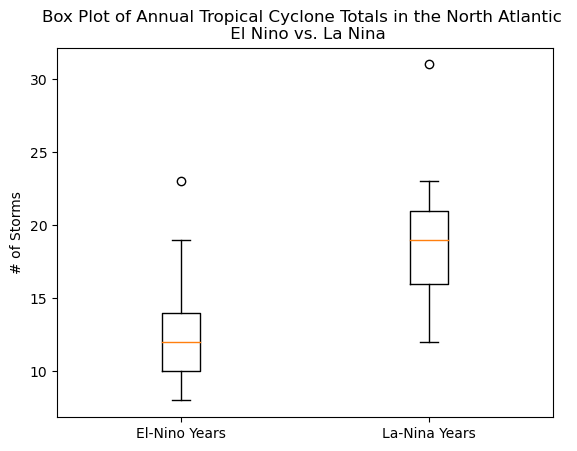

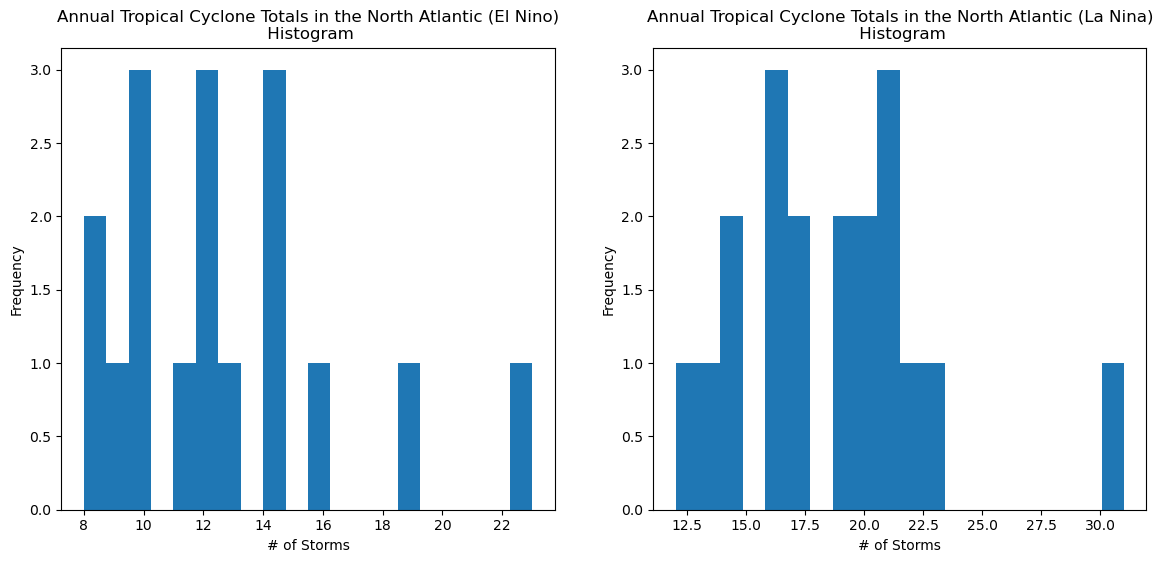

In [304]:
# Histograms & Box plots for Atlantic Basin - Annual Storm Total

# Plots (Box plot) for Annual Storm Totals 
fig,ax = plt.subplots()
ax.boxplot([Atlantic_El_Nino_Stats['Number_of_Storms'],Atlantic_La_Nina_Stats['Number_of_Storms']])
ax.set_xticklabels(['El-Nino Years', 'La-Nina Years'])
ax.set_ylabel('# of Storms')
ax.set_title('Box Plot of Annual Tropical Cyclone Totals in the North Atlantic \n El Nino vs. La Nina')

# Histogram for Annual Storm Totals 
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].hist(Atlantic_El_Nino_Stats['Number_of_Storms'],bins=20)
ax[0].set_title('Annual Tropical Cyclone Totals in the North Atlantic (El Nino)\n Histogram') 
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('# of Storms')

ax[1].hist(Atlantic_La_Nina_Stats['Number_of_Storms'],bins=20)
ax[1].set_title('Annual Tropical Cyclone Totals in the North Atlantic (La Nina)\n Histogram') 
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('# of Storms')


# Discussion 

Some key takeaways from the plots above for the Atlantic Basin 

1) Box plots indicate a strong impact of El-Nino and La-Nina on total number of storms in a year. The box plot data aligns with our hypothesis - that El-Nino is associated with fewer storms, and La-Nina is associated with more storms. There is a lot of variance in each category, but the medians and interquartile ranges definitely showcase the difference. The shape of the box plots and the locations of the median indicate the data does not look normally distributed, which segues nicely into the discussion on the histograms. <br> 

2) The histograms of # of tropical cyclones a year for El-Nino/La-Nina show three key things. First, it's quite apparent that we are working with small sample sizes. Second, the values clearly show that La-Nina years are more likely to have more storms. Third, because of the small sample sizes, the distribution "shapes" look different. This will be important to consider when we attempt to fit a distribution to this data (which will be discussed later). I experimented with different bin sizes and found 20 to be a good value. 


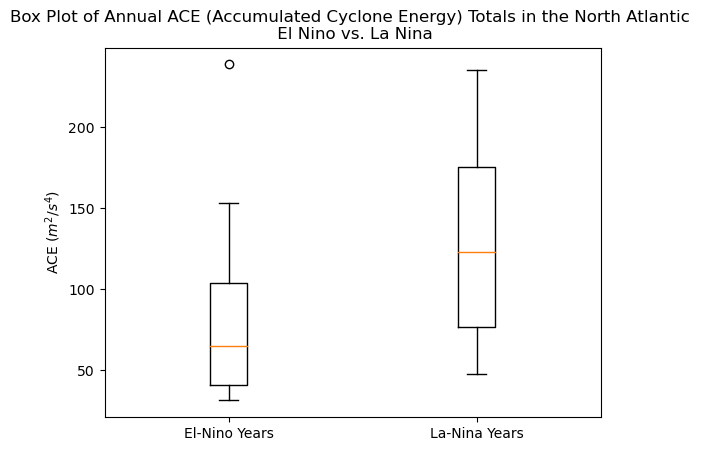

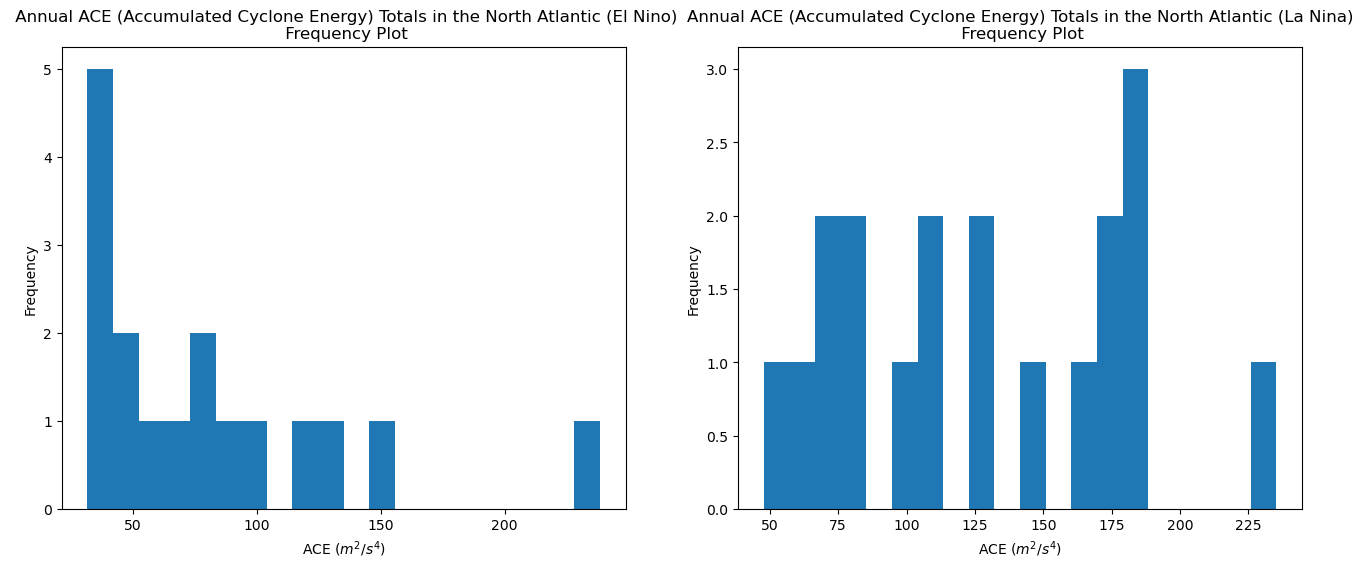

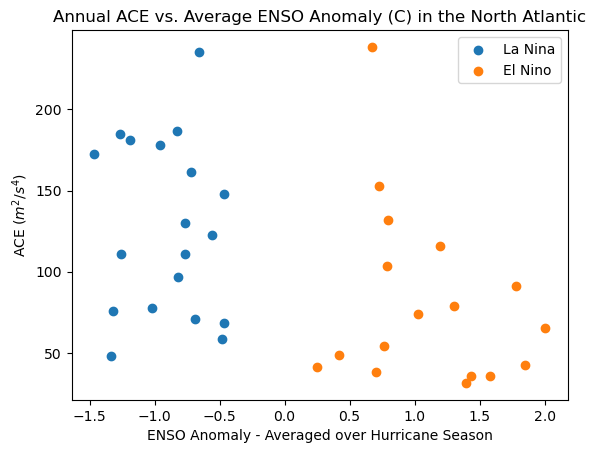

In [308]:
# Plots (Box plot, Histogram, Scatter Plot) for Accumulated Cyclone Energy, North Atlantic 

# Box Plot 
fig,ax = plt.subplots()
ax.boxplot([Atlantic_El_Nino_Stats['ACE'],Atlantic_La_Nina_Stats['ACE']])
ax.set_xticklabels(['El-Nino Years', 'La-Nina Years'])
ax.set_ylabel('ACE ($m^2$/$s^4$)')
ax.set_title('Box Plot of Annual ACE (Accumulated Cyclone Energy) Totals in the North Atlantic \n El Nino vs. La Nina')

# Histogram 
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].hist(Atlantic_El_Nino_Stats['ACE'],bins=20)
ax[0].set_title(' Annual ACE (Accumulated Cyclone Energy) Totals in the North Atlantic (El Nino)\n Frequency Plot') 
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('ACE ($m^2$/$s^4$)')

ax[1].hist(Atlantic_La_Nina_Stats['ACE'],bins=20)
ax[1].set_title('Annual ACE (Accumulated Cyclone Energy) Totals in the North Atlantic (La Nina)\n Frequency Plot') 
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('ACE ($m^2$/$s^4$)')

#Scatter Plot - ACE vs. Season ENSO Anomaly
fig,ax=plt.subplots()
ax.scatter(Atlantic_La_Nina_Stats['ENSO_Anom_Yr'],Atlantic_La_Nina_Stats['ACE'],label='La Nina')
ax.scatter(Atlantic_El_Nino_Stats['ENSO_Anom_Yr'],Atlantic_El_Nino_Stats['ACE'],label='El Nino')
ax.set_title('Annual ACE vs. Average ENSO Anomaly (C) in the North Atlantic')
ax.set_xlabel('ENSO Anomaly - Averaged over Hurricane Season')
ax.set_ylabel('ACE ($m^2$/$s^4$)')
plt.legend()

# Discussion 

Some key takeaways from the above ACE plots for the Atlantic Basin 

1) Box plots indicate a strong impact of El-Nino and La-Nina on ACE, in the direction that we hypothesized. El-Nino seems to have fewer storms, and the storms that do form appear to be weaker. The La-Nina data looks normally distributed but it could be an artifact of small sample size. <br>


2) The histograms of # of tropical cyclones a year for El-Nino/La-Nina also highlight the trend, but what is jarring is how different the El-Nino/La-Nina distributions are. Small sample sizes are likely a culprit, but it seems like El-Nino ACE data follows an extreme gamma distribution, while La-Nina looks "normal" <br>

3) A scatter plot of ACE vs. ENSO anomaly (averaged over the entire hurricane season) shows a noisy but clear negative trend (as expected). This could be interesting data to do a linear regression on! <br>


Text(0.5, 0, '# of Landfalling Storms')

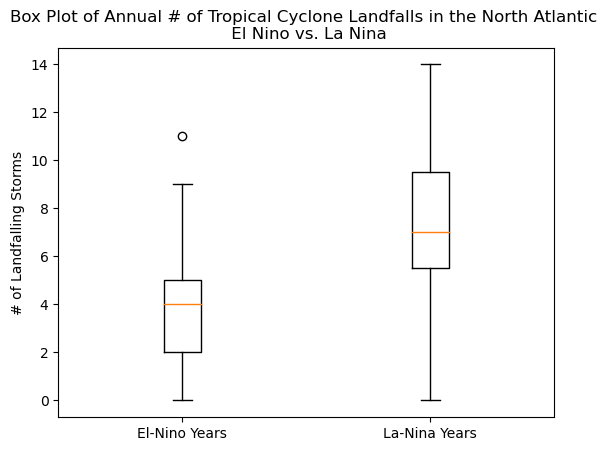

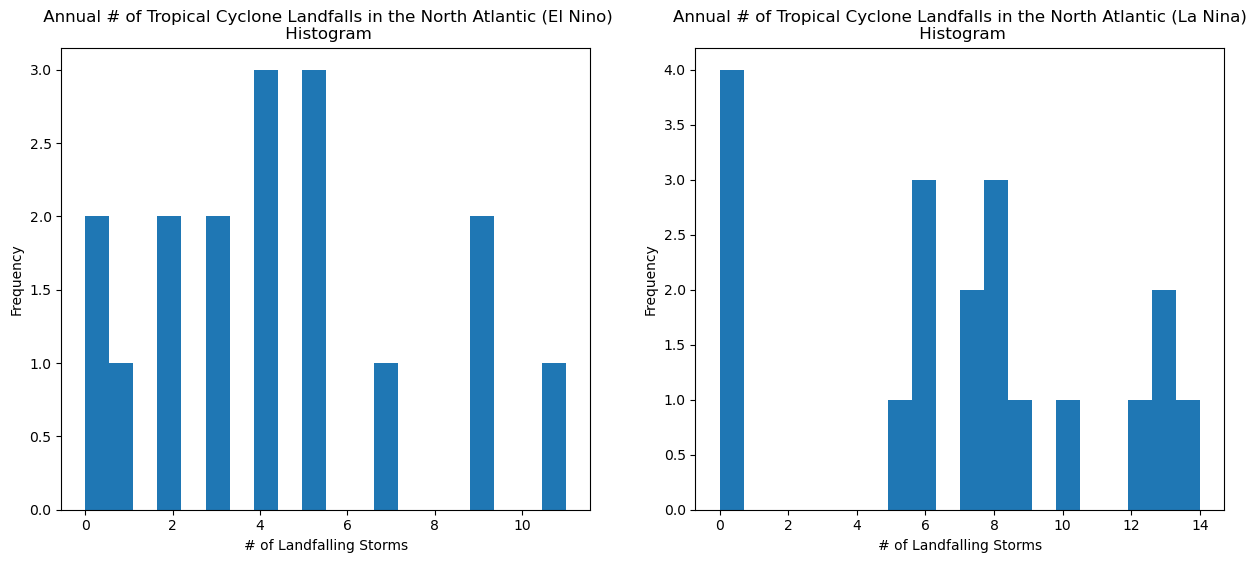

In [307]:
# Plots (Box plot & Density) for # of annual landfalling tropical cyclones, North Atlantic 

fig,ax = plt.subplots()
ax.boxplot([Atlantic_El_Nino_Stats['Number_Landfalling_Storms'],Atlantic_La_Nina_Stats['Number_Landfalling_Storms']])
ax.set_xticklabels(['El-Nino Years', 'La-Nina Years'])
ax.set_ylabel('# of Landfalling Storms')
ax.set_title('Box Plot of Annual # of Tropical Cyclone Landfalls in the North Atlantic \n El Nino vs. La Nina')

fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(Atlantic_El_Nino_Stats['Number_Landfalling_Storms'],bins=20)
ax[0].set_title(' Annual # of Tropical Cyclone Landfalls in the North Atlantic (El Nino)\n Histogram') 
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('# of Landfalling Storms')

ax[1].hist(Atlantic_La_Nina_Stats['Number_Landfalling_Storms'],bins=20)
ax[1].set_title('Annual # of Tropical Cyclone Landfalls in the North Atlantic (La Nina)\n Histogram') 
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('# of Landfalling Storms')

# Discussion

Some key takeaways from the above # of landfall plots for the Atlantic Basin

1) As expected, we see fewer storms making landfall in an El-Nino vs. a La-Nina. <br>

2) This data also seems affected by small sample sizes 


Text(0.5, 0, '# of Storms')

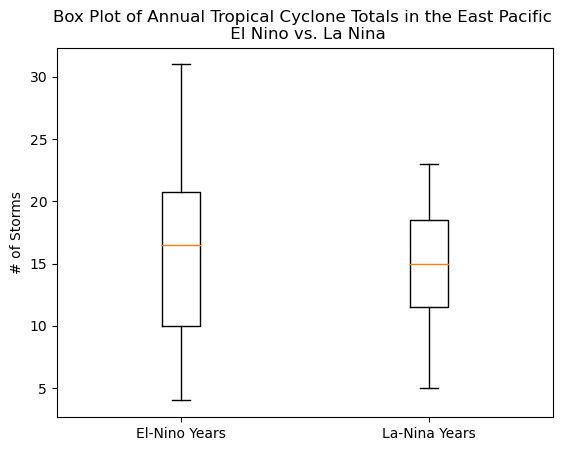

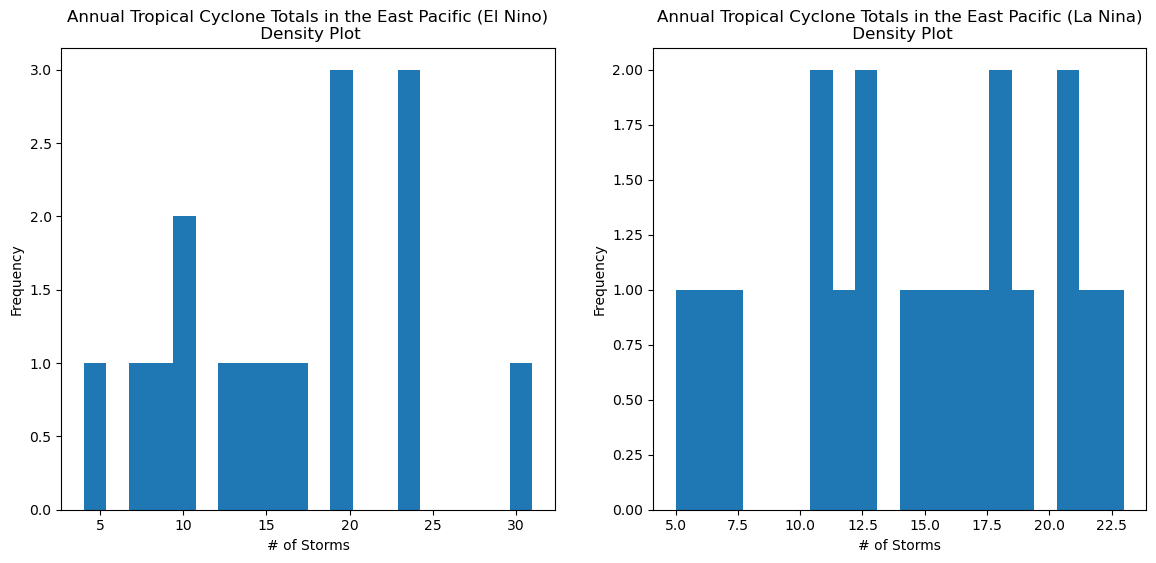

In [309]:
#Exploratory Data Analysis - Histograms & Box plots for Pacific Basin (for all relevant metrics) 

# Plots (Box plot & Density) for Annual Storm Totals  

fig,ax = plt.subplots() 

ax.boxplot([Pacific_El_Nino_Stats['Number_of_Storms'],Pacific_La_Nina_Stats['Number_of_Storms']]) 

ax.set_xticklabels(['El-Nino Years', 'La-Nina Years']) 

ax.set_ylabel('# of Storms') 

ax.set_title('Box Plot of Annual Tropical Cyclone Totals in the East Pacific \n El Nino vs. La Nina') 

  

fig,ax = plt.subplots(1,2,figsize=(14,6)) 

ax[0].hist(Pacific_El_Nino_Stats['Number_of_Storms'],bins=20) 

ax[0].set_title('Annual Tropical Cyclone Totals in the East Pacific (El Nino)\n Density Plot')  

ax[0].set_ylabel('Frequency') 

ax[0].set_xlabel('# of Storms') 

  

ax[1].hist(Pacific_La_Nina_Stats['Number_of_Storms'],bins=20) 

ax[1].set_title('Annual Tropical Cyclone Totals in the East Pacific (La Nina)\n Density Plot')  

ax[1].set_ylabel('Frequency') 

ax[1].set_xlabel('# of Storms') 

 

# Discussion 

Some key takeaways from the plot above. 

According to researchers, ENSO affects the Atlantic & Pacific Basins in opposite ways. El-Nino should increase storm count in the Eastern Pacific, while decreasing it in the Atlantic, and vice versa for La-Nina. This is what we are seeing here, but it is interesting to note that the effect does not seem as pronounced as in the Atlantic Basin. <br>

Based on the histograms, if you squint, the data looks somewhat normal but again sample sizes are small. 

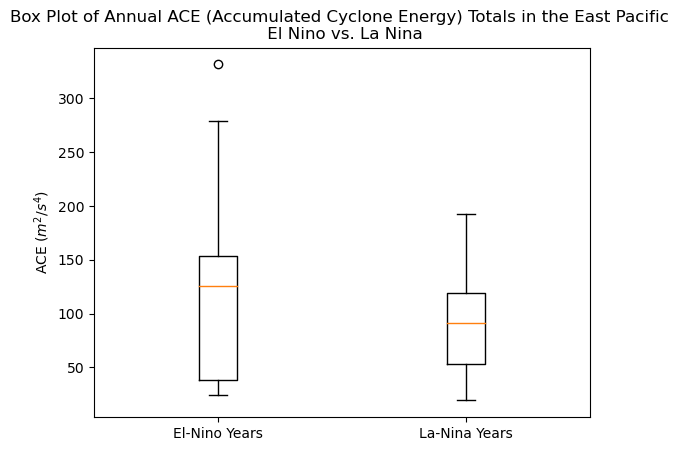

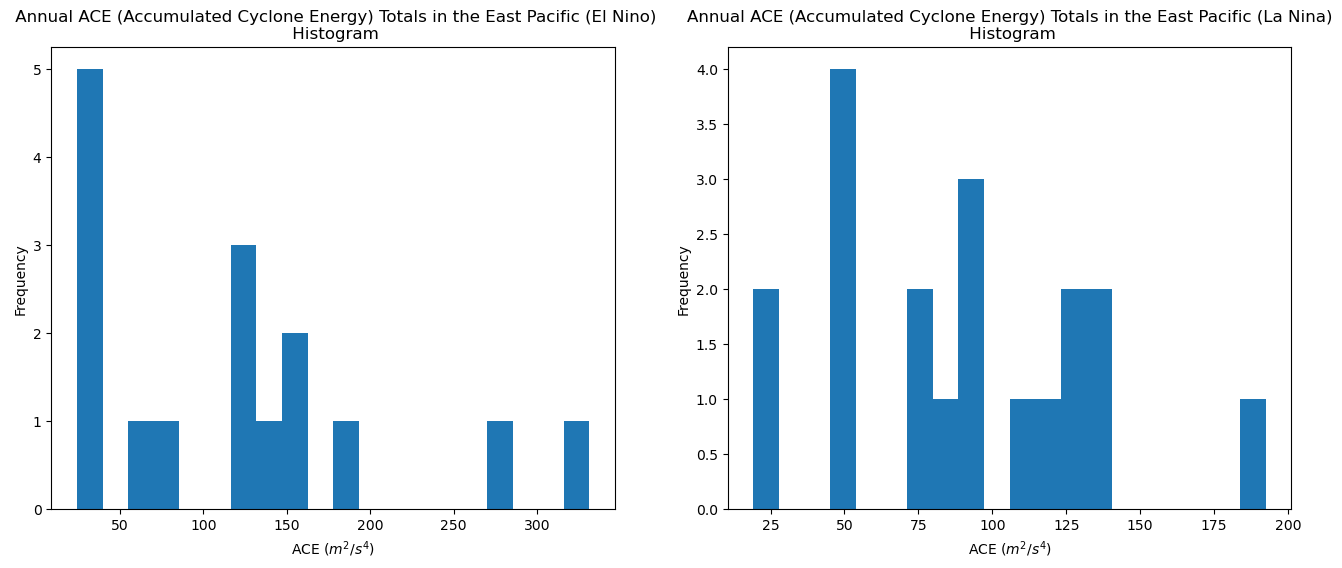

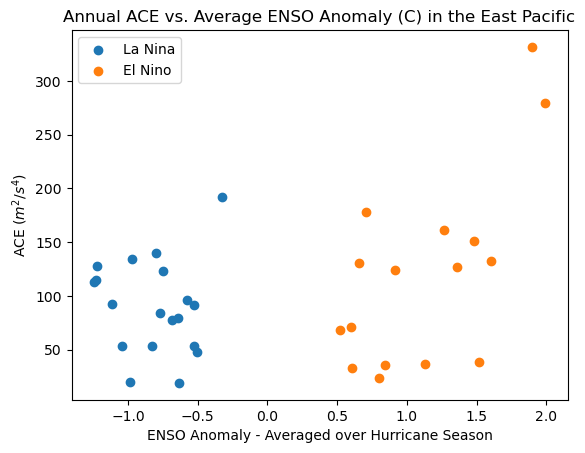

In [310]:
# Plots (Box plot & Density) for Accumulated Cyclone Energy, East Pacific  

  

fig,ax = plt.subplots() 

ax.boxplot([Pacific_El_Nino_Stats['ACE'],Pacific_La_Nina_Stats['ACE']]) 

ax.set_xticklabels(['El-Nino Years', 'La-Nina Years']) 

ax.set_ylabel('ACE ($m^2$/$s^4$)') 

ax.set_title('Box Plot of Annual ACE (Accumulated Cyclone Energy) Totals in the East Pacific \n El Nino vs. La Nina') 

  

fig,ax = plt.subplots(1,2,figsize=(16,6)) 

ax[0].hist(Pacific_El_Nino_Stats['ACE'],bins=20) 

ax[0].set_title(' Annual ACE (Accumulated Cyclone Energy) Totals in the East Pacific (El Nino)\n Histogram')  

ax[0].set_ylabel('Frequency') 

ax[0].set_xlabel('ACE ($m^2$/$s^4$)') 

  

ax[1].hist(Pacific_La_Nina_Stats['ACE'],bins=20) 

ax[1].set_title('Annual ACE (Accumulated Cyclone Energy) Totals in the East Pacific (La Nina)\n Histogram')  

ax[1].set_ylabel('Frequency') 

ax[1].set_xlabel('ACE ($m^2$/$s^4$)')

fig,ax=plt.subplots()
ax.scatter(Pacific_La_Nina_Stats['ENSO_Anom_Yr'],Pacific_La_Nina_Stats['ACE'],label='La Nina')
ax.scatter(Pacific_El_Nino_Stats['ENSO_Anom_Yr'],Pacific_El_Nino_Stats['ACE'],label='El Nino')
ax.set_title('Annual ACE vs. Average ENSO Anomaly (C) in the East Pacific')
ax.set_xlabel('ENSO Anomaly - Averaged over Hurricane Season')
ax.set_ylabel('ACE ($m^2$/$s^4$)')
plt.legend()

# Discussion

Key takeaways from the plots above. 

From the box plots, it appears that El-Nino years have greater seasonal ACE values, but there definitely is an issue of an outlier skewing the data high. This can be seen in the histogram data as well, but I believe it is most apparent when you look at the scatter plot of Annual ACE vs. Average ENSO Anomaly for a given year. There are two big El-Nino outliers with huge ACE values, and it is interesting to note that that both data points have the greatest positive ENSO anomalies (averaged over a season). However, remove those points and I don't think you see much of a trend. 

Text(0.5, 0, '# of Landfalling Storms')

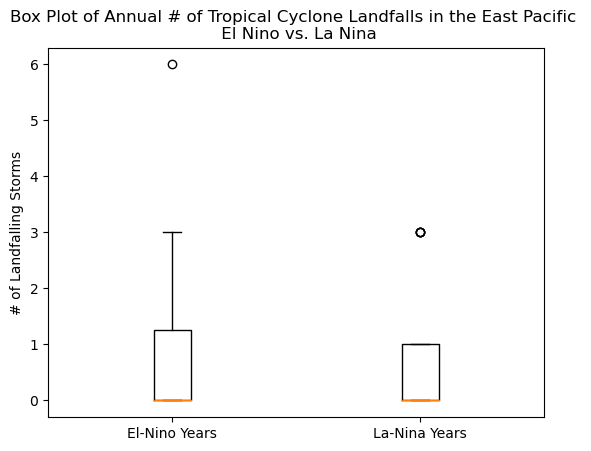

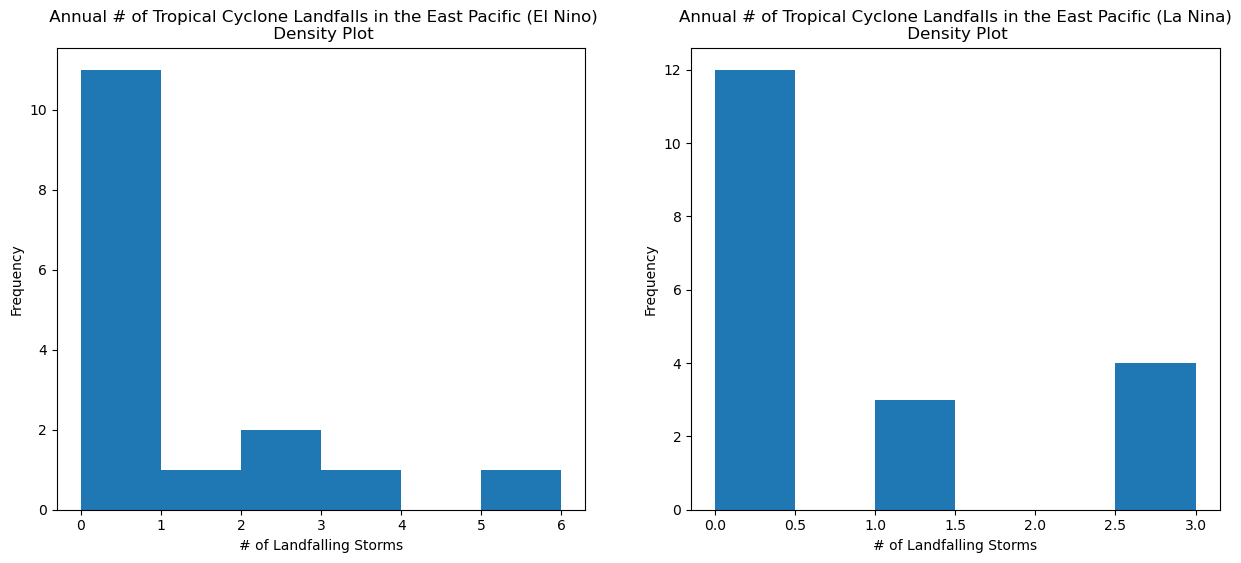

In [311]:
# Plots (Box plot & Density) for # of annual landfalling tropical cyclones, East Pacific  

fig,ax = plt.subplots() 

ax.boxplot([Pacific_El_Nino_Stats['Number_Landfalling_Storms'],Pacific_La_Nina_Stats['Number_Landfalling_Storms']]) 

ax.set_xticklabels(['El-Nino Years', 'La-Nina Years']) 

ax.set_ylabel('# of Landfalling Storms') 

ax.set_title('Box Plot of Annual # of Tropical Cyclone Landfalls in the East Pacific \n El Nino vs. La Nina') 

  

fig,ax = plt.subplots(1,2,figsize=(15,6)) 

ax[0].hist(Pacific_El_Nino_Stats['Number_Landfalling_Storms'],bins=6) 

ax[0].set_title(' Annual # of Tropical Cyclone Landfalls in the East Pacific (El Nino)\n Density Plot')  

ax[0].set_ylabel('Frequency') 

ax[0].set_xlabel('# of Landfalling Storms') 

ax[1].hist(Pacific_La_Nina_Stats['Number_Landfalling_Storms'],bins=6) 

ax[1].set_title('Annual # of Tropical Cyclone Landfalls in the East Pacific (La Nina)\n Density Plot')  

ax[1].set_ylabel('Frequency') 

ax[1].set_xlabel('# of Landfalling Storms') 

# Discussion 

From the plots above, we can see we have a serious sample size issue - most values are zero, and I am extremely skeptical that any statistical analysis we do on this data will be statistically significant. There just aren't many landfalling tropical cyclones in the Eastern Pacific! 

# Summary of Data Analysis (For Atlantic & Pacific Basins) 

# Analysis #1 - Total # storms/year for El-Nino/La-Nina 
- Since this is a discrete distribution, first attempted to fit poisson distribution onto histograms (see below)
- Results seen in plot below indicate that poisson distribution significantly undershoots actual data.
- Therefore sought out alternative hypothesis test for this analysis: <b> Mann-Whitney U test </b>
    - Null Hypothesis: No difference b/w groups. Alternative hypothesis: There is a difference b/w groups. Therefore, one group has greater values than the other. 
    - Test is non-parametric (assumes no particular distribution), robust to outliers, and does not assume both groups being compared have the same variance. 
    - Test outputs 2 values: U-statistic, which measures the degree of difference b/w two groups, and p-value. A p value below 0.05 means we can reject the null hypothesis and assume the differences b/w two samples are statistically significant. 
    
# Analysis #2 - Relationship between ACE and average ENSO anomaly per season 

- Univariate linear regression model created using scatterplot data shown in the exploratory data analysis section 
- Want to test how strong the relationship is between the two variables & evaluate its statistical significance & other properties 

# Analysis #3 - Total # of landfalling storms/year for El-Nino/La-Nina
- Similar to analysis #1, using Mann-Whitney U test because the characteristics of this data is similar. 


Text(0.5, 0, 'Number of landfalling hurricanes')

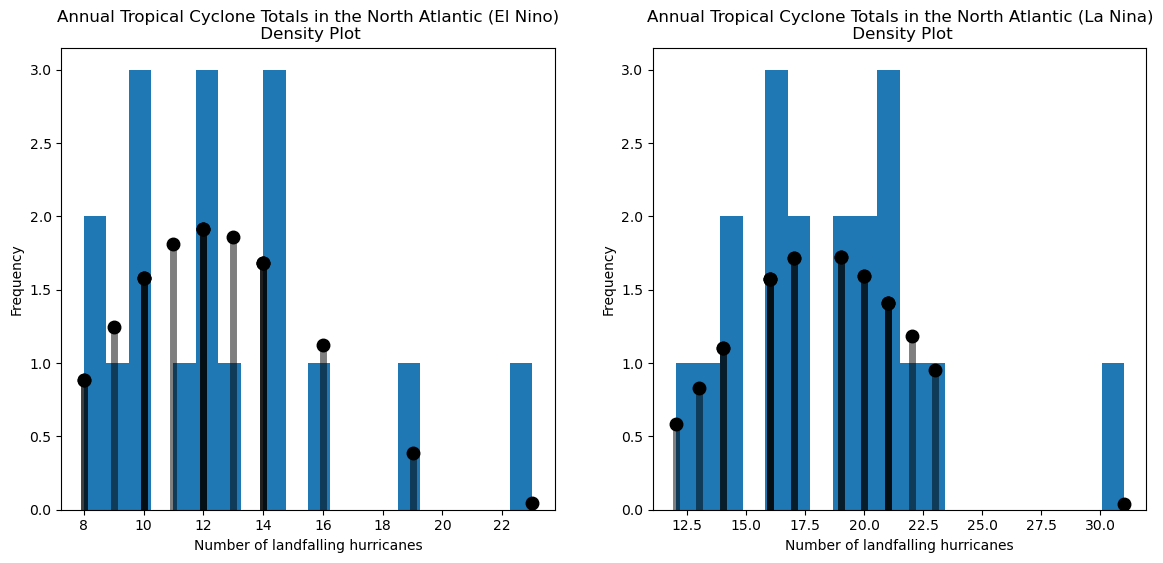

In [335]:
# Statistical Analysis for Atlantic Basin 

# First try Poisson on Atlantic # of storm data 

# Histogram Data 

#El Nino

fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].hist(Atlantic_El_Nino_Stats['Number_of_Storms'],bins=20)
ax[0].set_title('Annual Tropical Cyclone Totals in the North Atlantic (El Nino)\n Density Plot') 
ax[0].set_ylabel('Discrete Probability [0-1]')
ax[0].set_xlabel('# of Storms')

# Plot Poisson 
mlest = Atlantic_El_Nino_Stats['Number_of_Storms'].mean() 

ax[0].plot(Atlantic_El_Nino_Stats['Number_of_Storms'], stats.poisson.pmf(Atlantic_El_Nino_Stats['Number_of_Storms'], mlest)*len(Atlantic_El_Nino_Stats['Number_of_Storms']), 'ko', markersize=9)

# Plot vertical lines extending down to make this easier to interpret
ax[0].vlines(Atlantic_El_Nino_Stats['Number_of_Storms'], 0, stats.poisson.pmf(Atlantic_El_Nino_Stats['Number_of_Storms'], mlest)*len(Atlantic_El_Nino_Stats['Number_of_Storms']), colors='k', lw=5, alpha=0.5)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Number of landfalling hurricanes')

# La Nina 

ax[1].hist(Atlantic_La_Nina_Stats['Number_of_Storms'],bins=20)
ax[1].set_title('Annual Tropical Cyclone Totals in the North Atlantic (La Nina)\n Density Plot') 
ax[1].set_ylabel('Discrete Probability [0-1]')
ax[1].set_xlabel('# of Storms')

# Plot Poisson 
mlest = Atlantic_La_Nina_Stats['Number_of_Storms'].mean() 

ax[1].plot(Atlantic_La_Nina_Stats['Number_of_Storms'], stats.poisson.pmf(Atlantic_La_Nina_Stats['Number_of_Storms'], mlest)*len(Atlantic_La_Nina_Stats['Number_of_Storms']), 'ko', markersize=9)

# Plot vertical lines extending down to make this easier to interpret
ax[1].vlines(Atlantic_La_Nina_Stats['Number_of_Storms'], 0, stats.poisson.pmf(Atlantic_La_Nina_Stats['Number_of_Storms'], mlest)*len(Atlantic_La_Nina_Stats['Number_of_Storms']), colors='k', lw=5, alpha=0.5)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Number of landfalling hurricanes')




In [321]:
# Now do Mann-Whitney U Test on Atlantic # of TC's 

# Run the Mann-Whitney U test
statistic, p_value = mannwhitneyu(Atlantic_El_Nino_Stats['Number_of_Storms'],Atlantic_La_Nina_Stats['Number_of_Storms'])

# Print the test statistic and p-value
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 45.0
p-value: 0.00022486170932267975


                            OLS Regression Results                            
Dep. Variable:                    ACE   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     7.874
Date:                Sun, 07 May 2023   Prob (F-statistic):            0.00824
Time:                        20:37:24   Log-Likelihood:                -193.19
No. Observations:                  36   AIC:                             390.4
Df Residuals:                      34   BIC:                             393.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          106.4951      8.891     11.978   

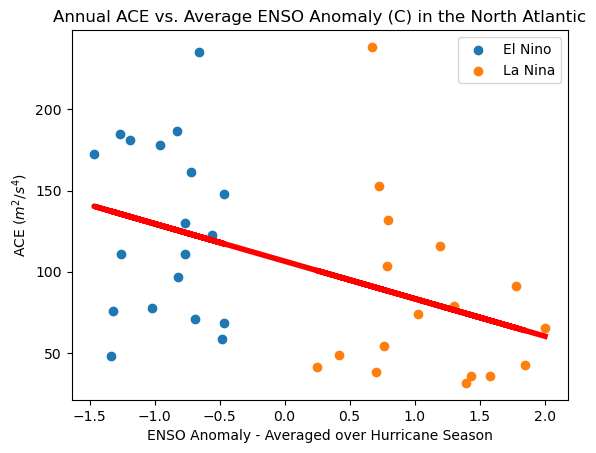

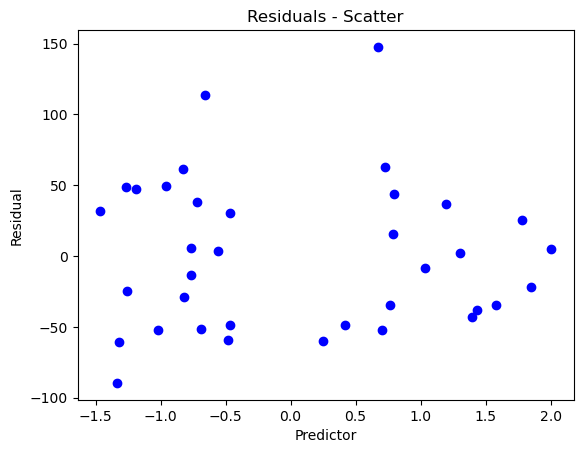

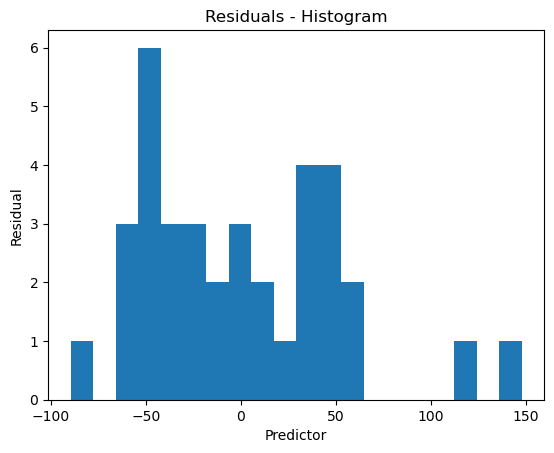

In [322]:
#Linear regression for ACE vs. Avg ENSO Anomaly, Atlantic

#Atlantic Basin 

fig,ax=plt.subplots()
ax.scatter(Atlantic_La_Nina_Stats['ENSO_Anom_Yr'],Atlantic_La_Nina_Stats['ACE'],label='El Nino')
ax.scatter(Atlantic_El_Nino_Stats['ENSO_Anom_Yr'],Atlantic_El_Nino_Stats['ACE'],label='La Nina')
ax.set_title('Annual ACE vs. Average ENSO Anomaly (C) in the North Atlantic')
ax.set_xlabel('ENSO Anomaly - Averaged over Hurricane Season')
ax.set_ylabel('ACE ($m^2$/$s^4$)')
plt.legend()

x = pd.concat([Atlantic_La_Nina_Stats['ENSO_Anom_Yr'],Atlantic_El_Nino_Stats['ENSO_Anom_Yr']])
y = pd.concat([Atlantic_La_Nina_Stats['ACE'],Atlantic_El_Nino_Stats['ACE']])

# I run the linear regression
x2 = sm.add_constant(x) # necessary if we want regression equation to have intercept

mod_uni = sm.OLS(y,x2).fit()
y_pred_uni = mod_uni.fittedvalues
print(mod_uni.summary())

ax.plot(x, y_pred_uni, color='red',linewidth=4)
plt.show()

# And here are the residuals from the regression! (Scatter)
fig,ax=plt.subplots()
ax.scatter(x, y-y_pred_uni,color='b')
ax.set_xlabel('Predictor')
ax.set_ylabel('Residual')
ax.set_title('Residuals - Scatter')
plt.show()

# And here are the residuals from the regression! (Histogram)
fig,ax=plt.subplots()
ax.hist(y-y_pred_uni,bins=20)
ax.set_xlabel('Predictor')
ax.set_ylabel('Residual')
ax.set_title('Residuals - Histogram')
plt.show()

# Model Improvement Example - Atlantic Basin ACE vs. ENSO Anomaly 

                            OLS Regression Results                            
Dep. Variable:                    ACE   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     11.40
Date:                Sun, 07 May 2023   Prob (F-statistic):            0.00120
Time:                        23:05:07   Log-Likelihood:                -388.46
No. Observations:                  72   AIC:                             780.9
Df Residuals:                      70   BIC:                             785.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          109.3795      6.377     17.153   

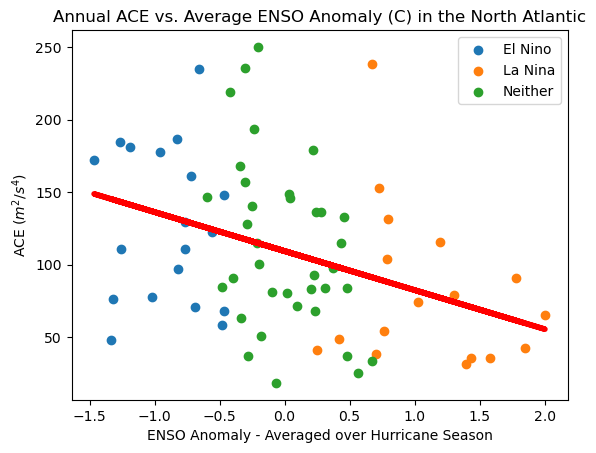

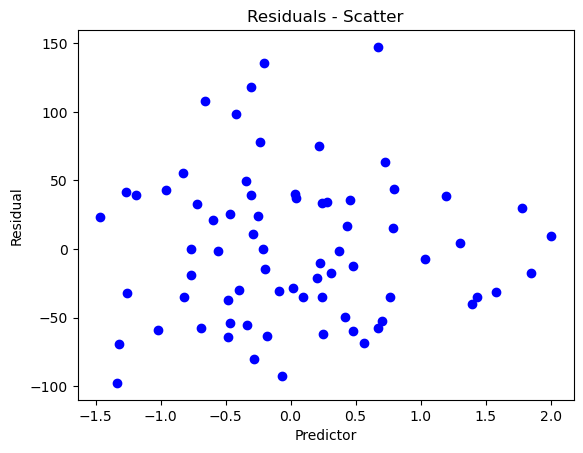

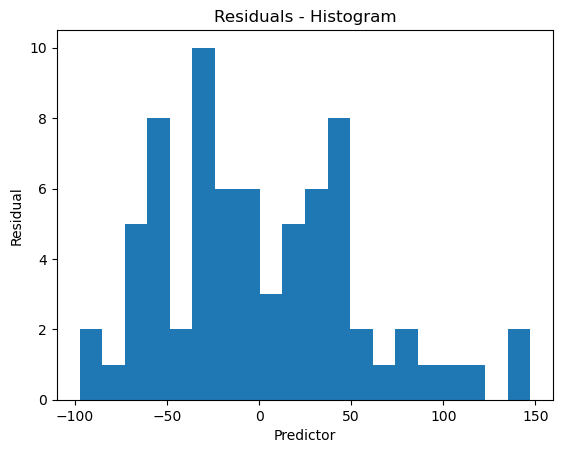

In [331]:
# Example of model-improvement: adding more data points to Atlantic Basin ACE vs. Average ENSO Anomaly. 
# In our previous analysis, I only analyzed years that fell into the "El-Nino" or "La-Nina" buckets. Now I will add
# data from all the years and see if I can generate a better regression model because of increased sample size

#Linear regression for ACE vs. Avg ENSO Anomaly, Atlantic

#Atlantic Basin 

fig,ax=plt.subplots()
ax.scatter(Atlantic_La_Nina_Stats['ENSO_Anom_Yr'],Atlantic_La_Nina_Stats['ACE'],label='El Nino')
ax.scatter(Atlantic_El_Nino_Stats['ENSO_Anom_Yr'],Atlantic_El_Nino_Stats['ACE'],label='La Nina')
ax.scatter(Atlantic_Not_Clear_Stats['ENSO_Anom_Yr'],Atlantic_Not_Clear_Stats['ACE'],label='Neither')

ax.set_title('Annual ACE vs. Average ENSO Anomaly (C) in the North Atlantic')
ax.set_xlabel('ENSO Anomaly - Averaged over Hurricane Season')
ax.set_ylabel('ACE ($m^2$/$s^4$)')
plt.legend()

x = pd.concat([Atlantic_La_Nina_Stats['ENSO_Anom_Yr'],Atlantic_El_Nino_Stats['ENSO_Anom_Yr'],Atlantic_Not_Clear_Stats['ENSO_Anom_Yr']])
y = pd.concat([Atlantic_La_Nina_Stats['ACE'],Atlantic_El_Nino_Stats['ACE'],Atlantic_Not_Clear_Stats['ACE']])

# I run the linear regression
x2 = sm.add_constant(x) # necessary if we want regression equation to have intercept

mod_uni = sm.OLS(y,x2).fit()
y_pred_uni = mod_uni.fittedvalues
print(mod_uni.summary())

ax.plot(x, y_pred_uni, color='red',linewidth=4)
plt.show()

# And here are the residuals from the regression! (Scatter)
fig,ax=plt.subplots()
ax.scatter(x, y-y_pred_uni,color='b')
ax.set_xlabel('Predictor')
ax.set_ylabel('Residual')
ax.set_title('Residuals - Scatter')
plt.show()

# And here are the residuals from the regression! (Histogram)
fig,ax=plt.subplots()
ax.hist(y-y_pred_uni,bins=20)
ax.set_xlabel('Predictor')
ax.set_ylabel('Residual')
ax.set_title('Residuals - Histogram')
plt.show()

In [323]:
# Statistical Analysis 
# MANN WHITNEY U - # of Landfalling Storms for Atlantic 

# Now do Mann-Whitney U Test on Atlantic # of TC's 

# Run the Mann-Whitney U test
statistic, p_value = mannwhitneyu(Atlantic_El_Nino_Stats['Number_Landfalling_Storms'],Atlantic_La_Nina_Stats['Number_Landfalling_Storms'])

# Print the test statistic and p-value
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 100.5
p-value: 0.05416179139171256


In [324]:
# Statistical Analysis for Pacific Basin 

# Now do Mann-Whitney U Test on Pacific # of TC's  

statistic, p_value = mannwhitneyu(Pacific_El_Nino_Stats['Number_of_Storms'],Pacific_La_Nina_Stats['Number_of_Storms']) 

# Print the test statistic and p-value 

print("Mann-Whitney U statistic:", statistic) 

print("p-value:", p_value) 

Mann-Whitney U statistic: 168.5
p-value: 0.5957519409268924


                            OLS Regression Results                            
Dep. Variable:                    ACE   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.382
Date:                Sat, 06 May 2023   Prob (F-statistic):             0.0267
Time:                        15:40:40   Log-Likelihood:                -194.66
No. Observations:                  35   AIC:                             393.3
Df Residuals:                      33   BIC:                             396.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          102.0763     10.989      9.289   

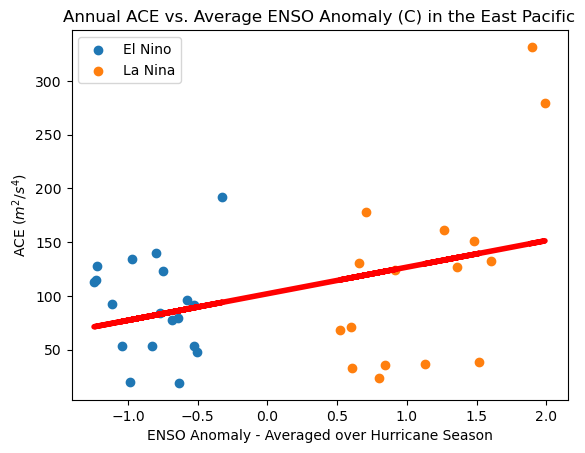

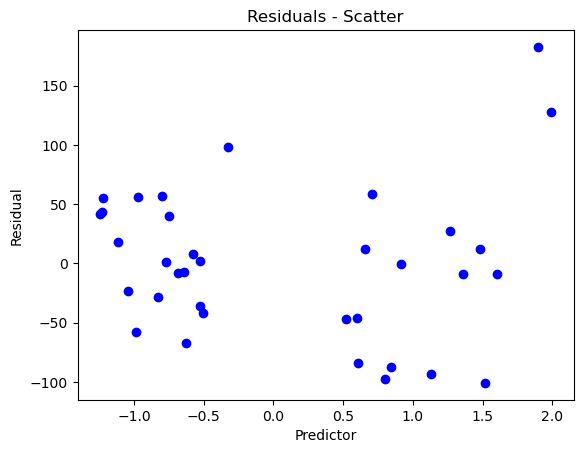

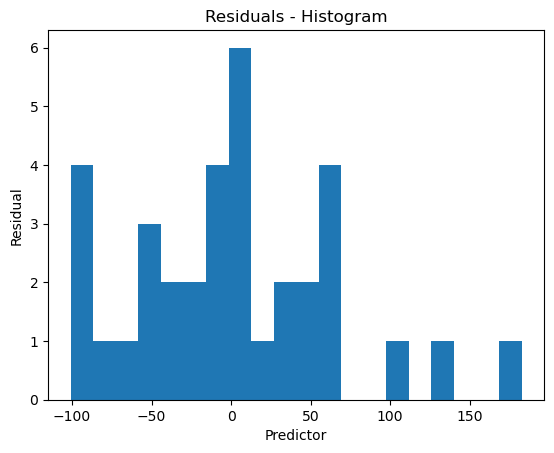

In [282]:
#Linear regression ACE, Pacific 
  
#Pacific Basin  

fig,ax=plt.subplots() 

ax.scatter(Pacific_La_Nina_Stats['ENSO_Anom_Yr'],Pacific_La_Nina_Stats['ACE'],label='El Nino') 

ax.scatter(Pacific_El_Nino_Stats['ENSO_Anom_Yr'],Pacific_El_Nino_Stats['ACE'],label='La Nina') 

ax.set_title('Annual ACE vs. Average ENSO Anomaly (C) in the East Pacific') 

ax.set_xlabel('ENSO Anomaly - Averaged over Hurricane Season') 

ax.set_ylabel('ACE ($m^2$/$s^4$)') 

plt.legend() 

  

x = pd.concat([Pacific_La_Nina_Stats['ENSO_Anom_Yr'],Pacific_El_Nino_Stats['ENSO_Anom_Yr']]) 

y = pd.concat([Pacific_La_Nina_Stats['ACE'],Pacific_El_Nino_Stats['ACE']]) 

  



x2 = sm.add_constant(x) # necessary if we want regression equation to have intercept 

  

mod_uni = sm.OLS(y,x2).fit() 

y_pred_uni = mod_uni.fittedvalues 

print(mod_uni.summary()) 


ax.plot(x, y_pred_uni, color='red',linewidth=4) 

plt.show() 

  

# And here are the residuals from the regression! (Scatter)

fig,ax=plt.subplots() 

ax.scatter(x, y-y_pred_uni,color='b') 

ax.set_xlabel('Predictor') 

ax.set_ylabel('Residual') 

ax.set_title('Residuals - Scatter') 

plt.show() 

  

# And here are the residuals from the regression! (Histogram)

fig,ax=plt.subplots() 

ax.hist(y-y_pred_uni,bins=20) 

ax.set_xlabel('Predictor') 

ax.set_ylabel('Residual') 

ax.set_title('Residuals - Histogram') 

plt.show() 

 

In [283]:
# Statistical Analysis  

# MANN WHITNEY U - # of Landfalling Storms for Pacific  

# Now do Mann-Whitney U Test on Pacific # of TC's  


# Run the Mann-Whitney U test 

statistic, p_value = mannwhitneyu(Pacific_El_Nino_Stats['Number_Landfalling_Storms'],Pacific_La_Nina_Stats['Number_Landfalling_Storms']) 

  
# Print the test statistic and p-value 

print("Mann-Whitney U statistic:", statistic) 

print("p-value:", p_value) 

Mann-Whitney U statistic: 145.5
p-value: 0.8138768313261439


# Results Discussion 

# Atlantic Basin 

# Analysis 1: Total # of storms/year for El-Nino/La-Nina 
- The Mann-Whitney U found that we can reject the null hypothesis that there are no differences b/w the two groups (p=0.000225). Therefore we can say that La-Nina and El-Nino year data are not identical groups, and that La-Nina years do have greater number of storms than El-Nino years (as we theorized) 
# Analysis 2: ACE vs. Average ENSO anomaly 
- Our linear regression has statistically significant constant and slope values - there is a sound linear relationship between the two values. 
- A slope value of -23 indicates an inverse relationship between ACE and Average ENSO anomaly - as we expect!
- HOWEVER: R^2 value of 0.188 (ouch!) indicates that most of the variance in ACE is NOT explained by variance in Average ENSO Anomaly! 
    - Makes sense as climate is extremely complex, so many difference variables at play. 
- Residuals look *fairly* normal (although it's hard to say for sure given small sample sizes) 
- Despite this, a trend *does* exist, in the direction we expect it to. 
- <b> Attempted to improve model by adding more data points </b> (from years without clear ENSO trend) 
    - R^2 value actually decreased to 0.140, but statistical significance of slope improved (although it already was statistically significant) 
    - Residuals look fairly normally distributed 
    
# Analysis 3: Total # of landfalling storms/year for El-Nino/La-Nina 
- Mann Whitney U test has a p value just *barely* above 0.05 (p=0.05416) 
- We cannot reject the null hypothesis. While there is clearly a difference in the number of storms that make landfall when looking at the two groups as a whole, this difference is *not* statistically significant. 
- However, one caveat is that literature states the Mann-Whitney U test has lower statistical power than other tests. This is a trade-off given its flexibility. 

# Pacific Basin 

# Analysis 1: Total # of storms/year for El-Nino/La-Nina 
- The Mann-Whitney U test we ran for this data has a p value of 0.595 which is comically bad. We certainly cannot reject the null hypothesis that there is no difference b/w annual storm totals for El-Nino & La-Nina years. 

# Analysis 2: ACE vs. Average ENSO anomaly 
- Lots of problems here! 
- Our linear regression has statistically significant constant and slope values (slope value = 24.7, p value = 0.027) 
- Slope is positive as we expected (El-Nino is correlated with more frequent & powerful tropical cyclones in East Pacific - opposite of Atlantic)
    - However, positive slope is likely due to the two high ACE outliers. Take those away and you likely have no clear pattern. Small sample sizes makes this tricky to decipher. 
- R^2 value is abysmal (0.140). Most variance in ACE is not explained by average ENSO anomaly 
- Durban Watson value of 1.139 suggests autocorrelation but based on the nature of the data (yearly data), I don't think this is true. I think the small sample sizes we're working with are skewing however this metric is calculated. 
- Residuals are showing a negative slope. I think this is because of the aforementioned outliers. 
- Therefore, while the regression model is statistically significant, I would be very wary to say there's a clear relationship here. 

# Analysis 3: Total # of landfalling storms/year for El-Nino/La-Nina 
- A p value of 0.813 plainly shows that we cannot reject the null hypothesis that there is no difference between total # of landfalling storms for El-Nino and La-Nina years 

# Conclusions 

# Atlantic Basin 
At a very high level, the statistical tests that we performed on our defined metrics point to our hypothesis being true. The Mann-Whitney U and linear regression tests both point to El-Nino having a detrimental effect on tropical cyclone formation and strength, and La-Nina having a positive effect. However, the analysis is not statistically significant when it comes to the effects of ENSO on number of landfalling tropical systems. One major issue complicating this analysis is the small sample sizes we were working with. 

# Pacific Basin 
From the exploratory data analysis, it seemed like the data metrics weakly lined up with our hypothesis - that El-Nino had a slight positive effect on tropical cyclone formation/development, and La-Nina had a slight detrimental effect. However, the effect is definitely not as strong as seen for the Atlantic basin. The hypothesis and regression testing all support this assessment - there may be a relationship there, but it is too weak to say anything with statistical significance. Like in the Atlantic data, small sample sizes was a big issue. 



# Future work 

I make some big simplifcations in my data analysis that definitely warrant improvement. For instance, in my analysis of Annual ACE vs. ENSO anomaly, I average the ENSO anomaly across the whole hurricane season and reduce it to a single value. By doing this, I lose a lot of nuance in the data. Under the hood, the ENSO value could be fluctuating in a number of different ways. One thing I'd be interested is doing a monthly analysis instead of a yearly analysis (i.e. look at ACE across all years for the month of July only). 

If I had more time, I would also explore doing a multi-variate linear regression for ACE vs. ENSO anomaly for the Atlantic Basin. Scientists have found a link between # of tropical cyclones and the Atlantic Multi-Decadal Oscillation (AMO), which is a mode of variability in sea surface temperatures in the North Atlantic Basin. By incorporating this variable, perhaps the linear regression could be improved. 




# Challenges
The biggest challenge was the small sample sizes for all of the analyses - this definitely made things much more complicated. 